/scratch/fstella/felix/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/matplotlibrc


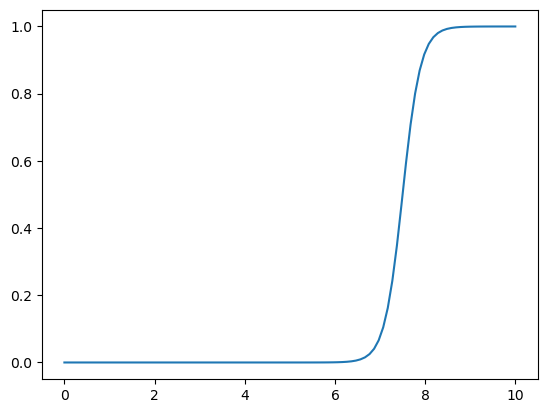

In [1]:
import numpy as np 
from neuron import PyramidalCells
from itertools import product
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def simulate_run(len_track = 200, av_running_speed = 20, dt = 0.01, tn = 1000):
    bins = np.arange(0., len_track)
    fps = 1/dt
    n_runs = int(2*tn/(len_track/av_running_speed))

    x = np.array([])
    i = 0
    while True:
        stopping_time = np.random.uniform(0, 1, 2)
        stop1 = np.ones((int(stopping_time[0]*fps),)) * 0.
        speed = av_running_speed + np.random.randn() * 5
        run_length = len(bins) * fps / speed
        run1 = np.linspace(0., float(len(bins)-1), int(run_length))
        stop2 = np.ones((int(stopping_time[1]*fps),)) * (len(bins)-1.)
        speed = av_running_speed + np.random.randn() * 5
        run_length = len(bins) * fps / speed
        run2 = np.linspace(len(bins)-1., 0., int(run_length))
        x = np.concatenate((x, stop1, run1, stop2, run2))
        if len(x) >= tn*fps:
            break
        i += 1

    x = x[:int(tn*fps)]
    t = np.arange(len(x))/fps

    return t, x

def get_firing_rates(pyramidal, event_count, x_run):

    firing_rates = np.zeros((event_count.shape[1], 1024))
    x_run_reshaped = np.zeros(1024)
    step_size = len(event_count)//firing_rates.shape[1]
    
    for i in range(firing_rates.shape[1]):
        firing_rates[:, i] = np.sum(event_count[i * step_size:(i + 1) * step_size, :], axis = 0) / (step_size*pyramidal.dt)
        if x_run is not None:
            x_run_reshaped[i] = np.mean(x_run[i * step_size:(i + 1) * step_size])

    return firing_rates, x_run_reshaped


def get_activation_map(firing_rates, m_EC, x_run_reshaped, top_down = True):

    out = np.zeros((firing_rates.shape[0], 32))
    position_bins = np.linspace(0, x_run_reshaped.max(), 32)
    bins = np.arange(32)
    n_cell = np.arange(firing_rates.shape[0])
    out_collector = {k : [] for k in product(n_cell, bins)}

    for idx, pos in enumerate(x_run_reshaped):
        bin_idx = np.argmin(np.abs(position_bins - pos))

        for i in range(firing_rates.shape[0]):
            out_collector[(i, bin_idx)].append(firing_rates[i, idx])

    for k, v in out_collector.items():
        out[k] = np.mean(v)

    # for idx, pos in enumerate(x_run_reshaped):
    #     bin_idx = np.argmin(np.abs(position_bins - pos))
    #     if out[:, bin_idx].sum() == 0:
    #         out[:, bin_idx] = firing_rates[:, idx] 
    #     else: 
    #         out[:, bin_idx] = (out[:, bin_idx] + firing_rates[:, idx]) / 2

    if top_down:
        sort_TD = np.argsort(m_EC)
    else:
        weighted_vals = out * np.arange(out.shape[1])[np.newaxis, :]
        m_EC = weighted_vals.sum(axis=1) / out.sum(axis=1)
        sort_TD = np.argsort(m_EC) 
        
    mean_firing_rates = out[np.ix_(sort_TD, np.arange(out.shape[1]))]

    return mean_firing_rates


def plot_firing_rates(fig, ax, firing_rates, m_EC, out, x_run_reshaped, top_down = True):

    ###### TODO:  IDEALLY I WOULD SOMEHOW PUT IT IN BINS ACCORDING TO POSITION AND THEN MEAN OVER THAT

    mean_firing_rates = get_activation_map(firing_rates, m_EC, x_run_reshaped, top_down = top_down)

    extent = [0, 100, 0, mean_firing_rates.shape[0]]
    n_active = np.sum(mean_firing_rates.mean(axis = 1) > 3)
    im = ax.imshow(mean_firing_rates, aspect='auto', extent=extent, origin='lower')
    fig.colorbar(im, ax=ax)
    ax.set_title(f"{out}; neurons active: {n_active}")
    ax.set_xlabel("Position (cm)")
    ax.set_ylabel("Neuron")

    return fig, ax, n_active


def simulate_for_env(pyramidal, len_track, speed, dt, tn, t_epoch, top_down, retrieval, new_env):
    t_run, x_run = simulate_run(len_track, speed, dt, tn)

    if retrieval:
        event_count, _ = pyramidal.retrieve_place_cells(t_run, x_run, new_env, a = 0, t_per_epoch = None, top_down = False, plasticity = False)
    else:
        event_count, _ = pyramidal.learn_place_cells(t_run, x_run, t_epoch, top_down = top_down)
    firing_rates, x_run_reshaped = get_firing_rates(pyramidal, event_count, x_run)
    mean_firing_rates = get_activation_map(firing_rates, pyramidal.m_EC, x_run_reshaped, top_down = top_down)

    return t_run, x_run, firing_rates, mean_firing_rates, x_run_reshaped


def plot_weights( W, m_CA3, m_EC):
    sort_CA3 = np.argsort(m_CA3)
    sort_EC = np.argsort(m_EC)

    fig, ax = plt.subplots(figsize = (10,8), dpi = 200)
    sorted_W = W[np.ix_(sort_EC, sort_CA3)]
    fig.colorbar(ax.imshow(sorted_W/np.sum(sorted_W)*50, origin='lower', aspect = 'auto'), ax=ax) # 50 n_pyr
    ax.set_title("CA3 weights")
    ax.set_xlabel("CA3 neuron")
    ax.set_ylabel("CA1 neuron")
    return fig, ax

Plasticity step: 1
Plasticity step: 2
Plasticity step: 3
Plasticity step: 4
Plasticity step: 5
Plasticity step: 6
Plasticity step: 7
Plasticity step: 8
Plasticity step: 9
Plasticity step: 10
Plasticity step: 11
Plasticity step: 12
Plasticity step: 13
Plasticity step: 14
Plasticity step: 15
Plasticity step: 16
Plasticity step: 17
Plasticity step: 18
Plasticity step: 19
Plasticity step: 20
Plasticity step: 21
Plasticity step: 22
Plasticity step: 23
Plasticity step: 24
Plasticity step: 25
Plasticity step: 26
Plasticity step: 27
Plasticity step: 28
Plasticity step: 29
Plasticity step: 30
Plasticity step: 31
Plasticity step: 32
Plasticity step: 33
Plasticity step: 34
Plasticity step: 35
Plasticity step: 36
Plasticity step: 37
Plasticity step: 38
Plasticity step: 39
Plasticity step: 40
Plasticity step: 41
Plasticity step: 42
Plasticity step: 43
Plasticity step: 44
Plasticity step: 45
Plasticity step: 46
Plasticity step: 47
Plasticity step: 48
Plasticity step: 49
Plasticity step: 50
Plasticit

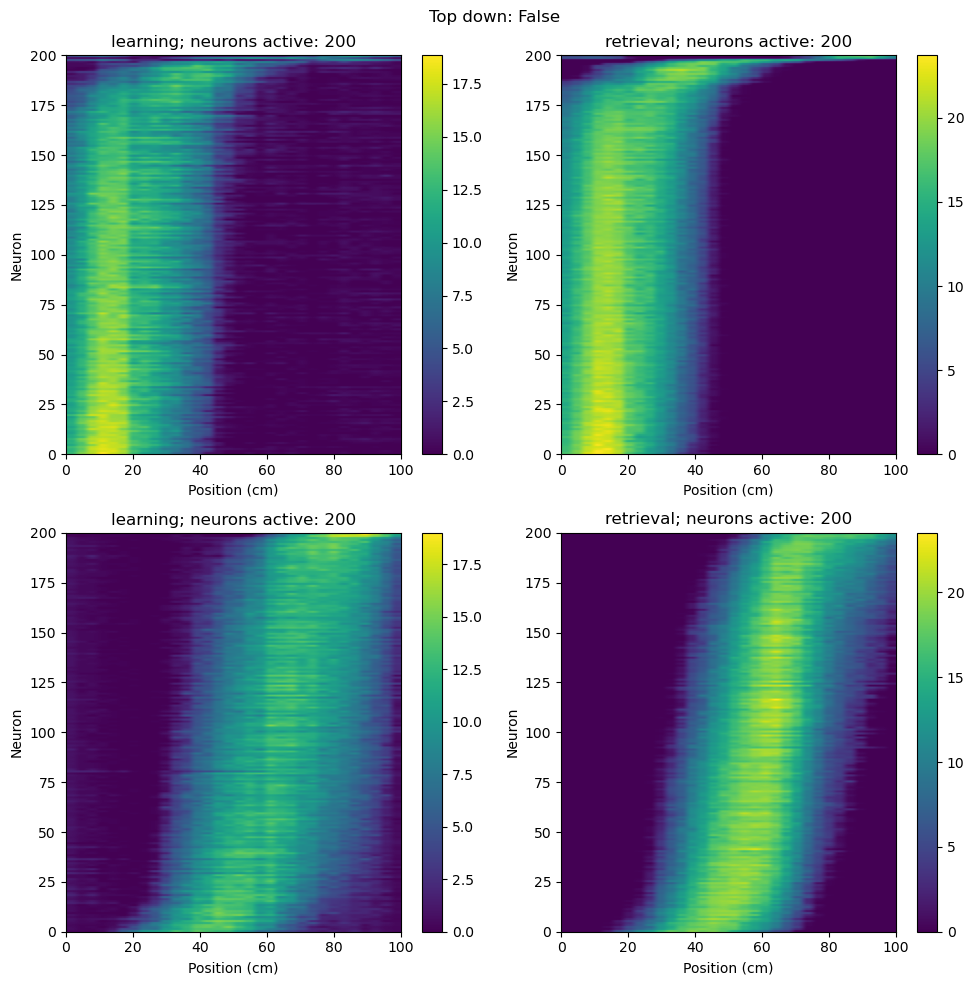

In [ ]:

lr = 1   # 5e-1
t_epoch = 1
speed = 20
len_track = 100. 
dt = 0.001
tn = len_track/speed*32
n_cells = {'pyramidal' : 200, 'inter_a' : 20, 'inter_b' : 20, 'CA3' : 120}
n_sim = 10
top_down = True
p_active = (1, 1)

for top_down in [ # True, 
        False
        ]:
    pyramidal = PyramidalCells(n_cells, learning_rate=lr, dt = dt, p_active = p_active)
    pyramidal.inh_plasticity = True
    pyramidal.alpha = 0 if top_down else 1
    pyramidal.lr_i_b = pyramidal.lr_i_b
    pyramidal.lr_i_a = pyramidal.lr_i_a
    pyramidal.W_ip_b = pyramidal.W_ip_b
    pyramidal.W_pi_b = pyramidal.W_pi_b

    # pyramidal.alpha_pre_spikes = .02

    pyramidal.rho_0_spikes = 15

    # pyramidal.rho_0_spikes_pre = 4.5
    # pyramidal.ma_pc, pyramidal.mb_pc = 120, 80
    pyramidal.inh_plasticity = False

    _, _, fr_learning1, mean_firing_rates_learning1, x_run_l1 = simulate_for_env(pyramidal, len_track, speed, dt, tn, t_epoch, 
                                                                    top_down, retrieval = False, new_env = False)

    _, _, fr_rt1, mean_firing_rates_retriev1, x_run_r1 = simulate_for_env(pyramidal, len_track, speed, dt, tn, t_epoch,
                                                                    top_down, retrieval = True, new_env = False)
    
    pyramidal.inh_plasticity = True
    
    _, _, fr_learning2, mean_firing_rates_learning2, x_run_l2 = simulate_for_env(pyramidal, len_track, speed, dt, tn, t_epoch, 
                                                                    top_down, retrieval = False, new_env = False)
    
    _, _, fr_rt2, mean_firing_rates_retriev2, x_run_r2 = simulate_for_env(pyramidal, len_track, speed, dt, tn, t_epoch,
                                                                    top_down, retrieval = True, new_env = False)
    
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax = ax.flatten()
    fig.suptitle(f"Top down: {str(top_down)}")
    plot_firing_rates(fig, ax[0], fr_learning1, pyramidal.m_EC, f'learning', x_run_l1, top_down = top_down)
    plot_firing_rates(fig, ax[1], fr_rt1, pyramidal.m_EC, f'retrieval', x_run_r1, top_down = top_down)
    plot_firing_rates(fig, ax[2], fr_learning2, pyramidal.m_EC, f'learning', x_run_l2, top_down = top_down)
    plot_firing_rates(fig, ax[3], fr_rt2, pyramidal.m_EC, f'retrieval', x_run_r2, top_down = top_down)
    plt.tight_layout()
    plt.show()

    plt.close()

    



[146  68 122 185  92 127  35  17 136  77  81 116 189  33  95 175 132  85
  72 183  29  38 172 137  36 139  76 102 110 195  24  34  94  71  48 174
 152 114  28 164 133  25 130 131  47  62 105  21 167  30  39  60  11 147
 108  51 103 162  74  73 120 181  31  18 191  57 109 158 115 186  26   7
 112  87  91  61 125 111  13  45  98 128 121  56  69 100 106  44  50 117
  42 123   0  49 140  14 169  40  96 143  65  75 134 194  63  32 124 119
  58 150 156 176 126 199 173 178  37 129 165 142 148  12  78 177 161 193
  99 184  52 118 141   9 154  59 138   3  84 163 196 170 107 188  15 197
 171 190  97 160  66 113  20  70 159 180 151  86   5   2  10 198  90  23
  41 155 187 104 166   4 182  22 149 145  43  53  93  67  16  88  83   8
  46  19 168  64  54  80   1 179  79  27 144 101 157   6  89  55 192 135
 153  82]


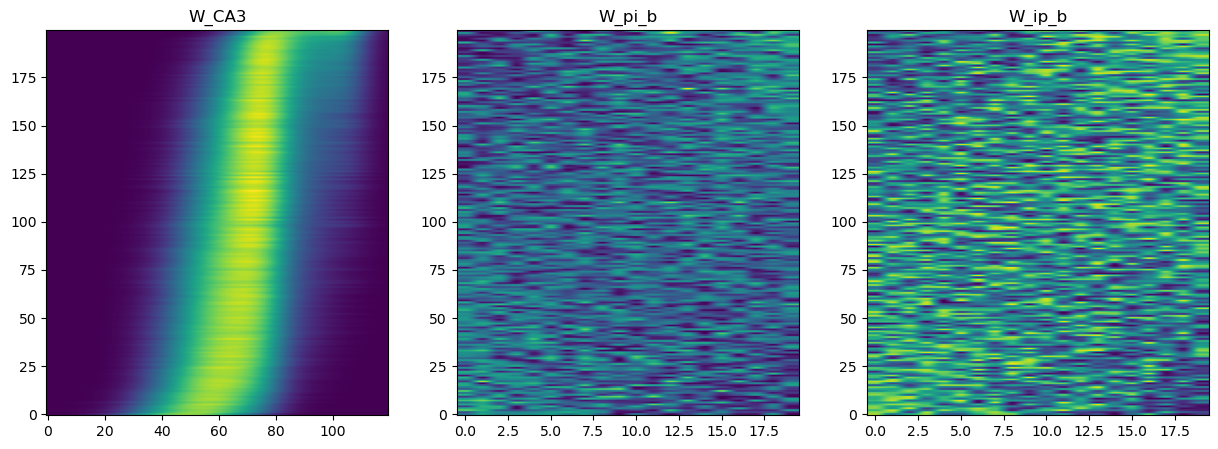

<Figure size 640x480 with 0 Axes>

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))


for i, W in enumerate([pyramidal.W_CA3, pyramidal.W_pi_b, pyramidal.W_ip_b]):
    if i == 2: 
        W = W.T

    if i == 0:
        sort_CA3 = np.argsort(pyramidal.m_CA3)
        W = W[np.ix_(np.arange(W.shape[0]), sort_CA3)]
    else: 
        W = W[np.ix_(sort_EC, np.arange(W.shape[1]))]

    weighted_vals = W * np.arange(W.shape[1])[np.newaxis, :] 
    m = weighted_vals.sum(axis=1) / W.sum(axis=1)
    sort_W = np.argsort(m) 

    if i == 0:
        sort_EC = sort_W
        print(sort_W)
        W_sorted = W[np.ix_(sort_W, np.arange(W.shape[1]))]

    else:
        W_sorted = W[np.ix_(sort_W, np.arange(W.shape[1]))]

    ax[i].imshow(W_sorted, aspect='auto', origin='lower')
    ax[i].set_title(['W_CA3', f'W_pi_b', f'W_ip_b'][i])

plt.show()
plt.tight_layout()

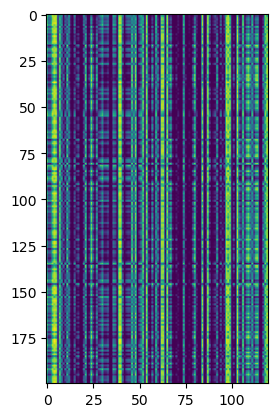

In [ ]:
plt.figure()
plt.imshow(pyramidal.W_CA3)
plt.show()

MN

In [6]:
sort_EC

array([146,  68, 122, 185,  92, 127,  35,  17, 136,  77,  81, 116, 189,
        33,  95, 175, 132,  85,  72, 183,  29,  38, 172, 137,  36, 139,
        76, 102, 110, 195,  24,  34,  94,  71,  48, 174, 152, 114,  28,
       164, 133,  25, 130, 131,  47,  62, 105,  21, 167,  30,  39,  60,
        11, 147, 108,  51, 103, 162,  74,  73, 120, 181,  31,  18, 191,
        57, 109, 158, 115, 186,  26,   7, 112,  87,  91,  61, 125, 111,
        13,  45,  98, 128, 121,  56,  69, 100, 106,  44,  50, 117,  42,
       123,   0,  49, 140,  14, 169,  40,  96, 143,  65,  75, 134, 194,
        63,  32, 124, 119,  58, 150, 156, 176, 126, 199, 173, 178,  37,
       129, 165, 142, 148,  12,  78, 177, 161, 193,  99, 184,  52, 118,
       141,   9, 154,  59, 138,   3,  84, 163, 196, 170, 107, 188,  15,
       197, 171, 190,  97, 160,  66, 113,  20,  70, 159, 180, 151,  86,
         5,   2,  10, 198,  90,  23,  41, 155, 187, 104, 166,   4, 182,
        22, 149, 145,  43,  53,  93,  67,  16,  88,  83,   8,  4

(20, 200) (200, 20)
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 

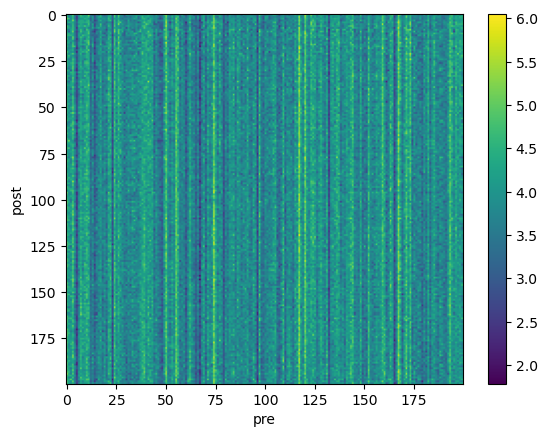

In [7]:
print(pyramidal.W_ip_b.shape, pyramidal.W_pi_b.shape)

print(pyramidal.W_pi_b.sum(axis=1))
print(pyramidal.W_ip_b.sum(axis=1))

W = pyramidal.W_pi_b @ pyramidal.W_ip_b

print(W.sum(axis=1))



W_sorted = W[np.ix_(sort_EC, sort_EC)]

plt.figure()
plt.imshow(W_sorted, aspect='auto')
plt.xlabel('pre')
plt.ylabel('post')
plt.colorbar()
plt.show()

In [ ]:
print(pyramidal.I_b(3).mean())

I_b = lambda t : np.ones(120) * 50
pyramidal.I_b = I_b
pyramidal.I_a = lambda t: np.zeros(200)

tn = 1024

pyramidal.run_one_epoch(tn, plasticity = False, inh_plasticity = False)

pyramidal.spike_count.shape


3.9508445653124373


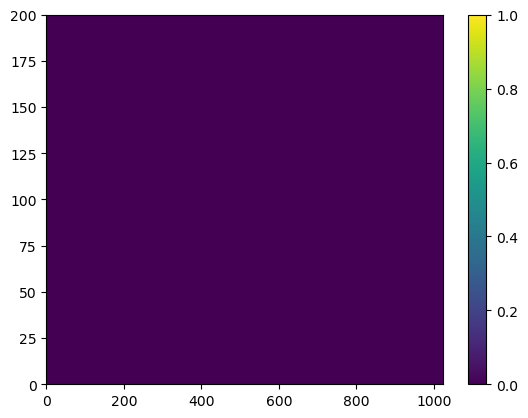

In [ ]:
fr, _ = get_firing_rates(pyramidal, pyramidal.spike_count, None)

fr = fr[np.ix_(sort_EC, np.arange(fr.shape[1]))]

plt.figure()
plt.imshow(fr, aspect='auto', extent=[0, tn, 0, fr.shape[0]])
plt.colorbar()
plt.show()


[6 7 9] 
 [[1 2 3]
 [4 2 1]
 [5 1 3]]


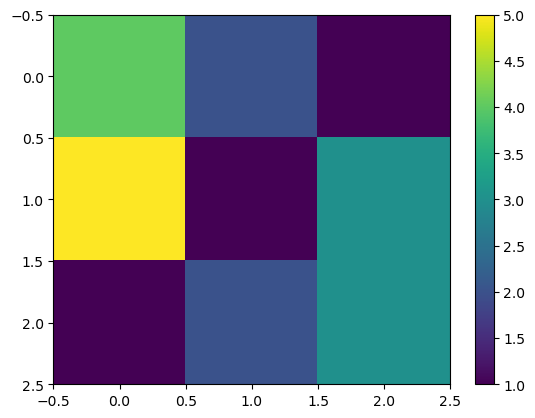

In [ ]:

W = np.array([[1, 2, 3], [4, 2, 1], [5, 1, 3]])

print(W.sum(axis=1), '\n', W)

plt.figure()

weighted_vals = W * np.arange(W.shape[1])[np.newaxis, :]
m = weighted_vals.sum(axis=1) / W.sum(axis=1)
sort_W = np.argsort(m) 
W_sorted = W[np.ix_(sort_W, np.arange(W.shape[1]))]
plt.imshow(W_sorted, aspect='auto')
plt.colorbar()
